In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

sector_size = 9 # size of the sector used to embed the secret message
idx = 5 # center of the sector


In [9]:
def convertHSV(img):
    return matplotlib.colors.rgb_to_hsv(img[:,:,:3].astype(np.float64))

def convertRGB(img):
    return matplotlib.colors.hsv_to_rgb(img.astype(np.float64))

def normalize(img):
    imgMin = np.min(img)
    imgMax = np.max(img)
    return (img-imgMin)/(imgMax-imgMin)

def floatV(img):
    return img[:,:,2].astype(np.float64)/255

def applyFFT(img):
    imgFFT = np.fft.fft2(img)
    return np.fft.fftshift(imgFFT)

def applyIFFT(img):
    imgShift = np.fft.ifftshift(img)
    imgIFFT = np.fft.ifft2(imgShift)
    return imgIFFT

# Main embedding function:
# We apply FFT on both images, then we divide the base image into 
# sectors of sector_size x sector_size.
# On the center of each sector (given by idx), we embed each secret message's frequency value
def encode(img1, img2):
    imgBase = applyFFT(np.copy(img1))
    height, width = imgBase.shape
    
    imgSecret = applyFFT(img2)
    imgSecretFlat = imgSecret.flatten()
    ind = 0
    
    if((height*width)/sector_size**2 < len(imgSecretFlat)):
        print('Encoding not possible')
    
    for x in range (0, height-idx, sector_size):
        for y in range (0, width-idx, sector_size):
            if ind < len(imgSecretFlat):
                imgBase[x+idx, y+idx] = imgSecretFlat[ind]
                ind += 1
            else:
                break
    return applyIFFT(imgBase)

# Main decoding function:
# Similar to the embedding function, we recover the secret message
# from the base image that was previously encoded
def decode(img1,key):
    imgBase = applyFFT(img1)
    height, width = imgBase.shape
    
    secret_h, secret_w = key
    secret = np.zeros((secret_h*secret_w), dtype=np.complex128)
    ind = 0
    for x in range (0, height-idx, sector_size):
        for y in range (0, width-idx, sector_size):
            if ind < len(secret):
                secret[ind] = imgBase[x+idx, y+idx]
                ind += 1
            else:
                break
    secret = secret.reshape((secret_h,secret_w))
    return applyIFFT(secret)

    

In [10]:
imgBaseName = './images/input.jpg'
imgSecretName = './images/qr.png'

# reading the base image
imgBase = plt.imread(imgBaseName)
imgBaseHSV = convertHSV(imgBase)
imgBaseV = floatV(imgBaseHSV)

# reading the secret message
imgSecret = plt.imread(imgSecretName)
imgSecretHSV = convertHSV(imgSecret)
imgSecretV = floatV(imgSecretHSV)

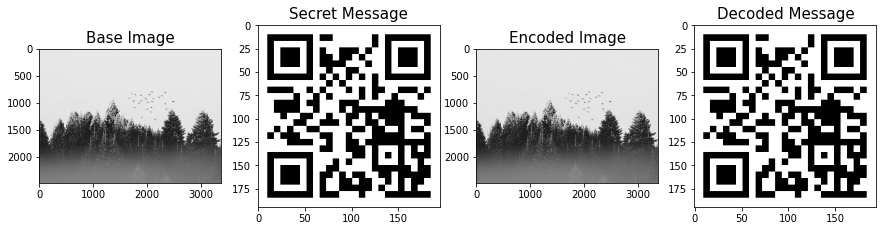

In [14]:
fig, ax = plt.subplots(1,4,figsize=(15,15))
ax[0].set_title('Base Image', fontsize = 15)
ax[0].imshow(imgBaseV, cmap='gray')

ax[1].set_title('Secret Message', fontsize = 15)
ax[1].imshow(imgSecretV, cmap='gray')

# embedding the secret message
encodedImageV = encode(imgBaseV, imgSecretV).real
encodedImage = imgBaseHSV
encodedImage[:,:,2] = encodedImageV.astype(np.float64)*255

# image used to remove some noise on the encoded image
blankImage = np.zeros(imgSecretV.shape)+1
noise = decode(encode(imgBaseV, blankImage).real, imgSecretV.shape)

# converting the image back to rgb and saving the encoded image
finalImage = np.copy(imgBase)
finalImage[:,:,:3] = convertRGB(encodedImage)
plt.imsave('./images/encoded.jpg', finalImage)
ax[2].set_title('Encoded Image', fontsize = 15)
ax[2].imshow(np.clip(encodedImageV.real, 0, 255), cmap='gray')

# retrieving the secret message thats embedded on the encoded image
secret = decode(encodedImageV,imgSecretV.shape).real
imageio.imsave('./images/decoded.png', (normalize(secret.real-noise.real)*255).astype(np.uint8))
ax[3].set_title('Decoded Message', fontsize = 15)
ax[3].imshow(normalize(secret.real-noise.real), cmap='gray')
